In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import glob
import pandas as pd
from PIL import Image

print(tf.__version__)


1.12.0


## Resize and process raw images

In [2]:
#folder = 'C:\\Users\\Sur lab\\Documents\\allenCCF3\\Data\\MouseC07'
folder = 'C:\\Users\\Sur lab\\Dropbox (MIT)\\Leica\\C07_LMN_092018_disynaptic_STRACC_mCherry_10x'
folder2 = 'C:\\Users\\Sur lab\Dropbox (MIT)\\Leica\\C20_LMN_CAVCreRACC_RabiesLACC_112618'
#folder = 'C:\\Users\\Sur lab\\Documents\\allenCCF3\\Data\\MouseC07\\Raw'
files = glob.glob(folder + '\\*\\*ch00.tif')
files2 = glob.glob(folder2 + '\\*ch00.tif')

In [3]:
order = np.array([0, 2, 4, 6, 8, 10, 1, 3, 5, 7, 9, 11,
                 12, 14, 16, 18, 20, 13, 15, 17, 19, 21,
                 22, 24, 26, 28, 30, 32, 23, 25, 27, 29, 31, 33,
                 34, 38, 42, 46, 50, 51, 52, 53,
                 35, 36, 37, 39, 40, 41, 43, 44, 45, 47, 48, 49, 55, 56])

In [4]:
def load_images(file_lst, save_folder, order=[], bad_images=[], flipped_images=[], imshape=(100, 40)):
    '''Load and filter out bad images
    Saves images in a folder'''
    if order == []:
        order = range(len(file_lst))
    count = 0
    imlst = []
    for i in range(len(order)):
        #print(im.height/40, im.width/40, i)
        if order[i] + 1 in bad_images:
            continue
        
        # Load, resize and flip
        im = Image.open(file_lst[order[i]])
        imresize = im.resize(imshape, Image.ANTIALIAS)
        if order[i] + 1 in flipped_images:
            imresize = imresize.transpose(Image.FLIP_TOP_BOTTOM)
            
        # Save image
        imresize.save(save_folder + str(i) + '_small.png')

In [5]:
save_folder = 'C07_small_new/C07_im'
save_folder2 = 'C20_small_new/C20_im'
load_images(files2, save_folder2, [], [], [])

## Load processed images

In [6]:
def find_matching_ylabel(filename, ytable):
    '''
    Returns the corresponding AP coordinate
    
    Inputs:
    - filename: the name of the image file *.tif
    - ytable: the AP coords in the form of a pd table
    
    Returns: the AP coordinate, None if no match
    '''
    for id, label_name in enumerate(ytable.Image):
        #print(id, label_name)
        if filename.startswith(label_name + '_'):
            return ytable.AP[id]
    
    print('Warning: no match')
    return None

In [7]:
def shuffle_datasets(X, y):
    '''Shuffle the datasets'''
    order = np.random.permutation(len(y))
    return X[order], y[order]
    
def load_dataset(folder, ylabel_file, num_training, num_validation, num_test):
    '''
    Loads a dataset
    
    Inputs:
    - filename: name of the file
    - ylabel_file: name of the ground truth label file
    
    Outputs:
    Xtrain, ytrain, Xval, yval, Xtest, ytest
    '''
    # Now load the labels
    y_table = pd.read_csv(ylabel_file)
    
    # Load the images in the folder
    files = glob.glob(folder)
    imlst = []
    y_train = []
    
    for file in files:
        filename = file.split('\\')[-1]
        im = Image.open(file)
                
        # Find the corresponding AP
        APval = find_matching_ylabel(filename, y_table)
        
        imlst.append(np.array(im))
        y_train.append(APval)
        #print(filename, APval)
        
    y_train = np.array(y_train)
    print(np.array(imlst).shape)
    X_train = np.array(imlst)[:,:,:,np.newaxis] # Dimension N x W x H x 1 (1 channel)
    assert len(y_train) == X_train.shape[0], "Training and labels mismatch in length"
    
    # Shuffle!
    X_train, y_train = shuffle_datasets(X_train, y_train)

    # Training and validation set
    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    
    mask = range(num_training + num_validation, num_training + num_validation + num_test)
    X_test = X_train[mask]
    y_test = y_train[mask]
    
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    

    # Normalize the data: subtract the mean pixel and divide by std
    #mean_pixel = X_train.mean(axis=(0, 1, 2), keepdims=True)
    #std_pixel = X_train.std(axis=(0, 1, 2), keepdims=True)
    #X_train = (X_train - mean_pixel) / std_pixel
    #X_val = (X_val - mean_pixel) / std_pixel
    #X_test = (X_test - mean_pixel) / std_pixel
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [8]:
def load_dataset_multiple(folder_lst, ylabel_lst, num_training, num_validation, num_test):
    '''
    Load from multiple folders
    
    Inputs:
    - folder_lst: list of folders
    - ylabel_lst: list of ylabel files
    - num_training: list or array of number of training in each file
    - num_validation: list of number of validation examples in each file
    - num_test: list of number of test examples in each file
    
    Returns: 
    Xtrain, ytrain, Xval, yval, Xtest, ytest
    '''
    X_train_all, y_train_all, X_val_all, y_val_all, X_test_all, y_test_all = [], [], [], [], [], []
    for folder, ylabel_file, ntrain, nval, ntest in zip(folder_lst, \
                                    ylabel_lst, num_training, num_validation, num_test):
        X_train, y_train, X_val, y_val, X_test, y_test = load_dataset(folder, \
                                            ylabel_file, ntrain, nval, ntest)
        print(y_train)
        X_train_all.append(X_train)
        y_train_all.append(y_train)
        X_val_all.append(X_val)
        y_val_all.append(y_val)
        X_test_all.append(X_test)
        y_test_all.append(y_test)
        
    # Concatenate and shuffle again
    X_train_all = np.concatenate(X_train_all)
    y_train_all = np.concatenate(y_train_all)
    X_val_all = np.concatenate(X_val_all)
    y_val_all = np.concatenate(y_val_all)
    X_test_all = np.concatenate(X_test_all)
    y_test_all = np.concatenate(y_test_all)
    
    X_train_all, y_train_all = shuffle_datasets(X_train_all, y_train_all)
    X_val_all, y_val_all = shuffle_datasets(X_val_all, y_val_all)
    X_test_all, y_test_all = shuffle_datasets(X_test_all, y_test_all)
    
    return X_train_all, y_train_all, X_val_all, y_val_all, \
            X_test_all, y_test_all

In [9]:
folder_lst = ['C:\\Users\\Sur lab\\Documents\\allenCCF\\C07_small\\*.png', \
             'C:\\Users\\Sur lab\\Documents\\allenCCF\\C20_small\\*.tif']
ylabel_lst = ['human_label_APcoords.csv', 'human_label_APcoords_C20.csv']
num_training = [40, 28]
num_validation = [6, 6]
num_test = [5, 4]

X_train, y_train, X_val, y_val, X_test, y_test = load_dataset_multiple(folder_lst, \
                                    ylabel_lst, num_training, num_validation, num_test)


(51, 80, 100)
[-3.1e+00  5.0e-02  3.0e-01 -2.0e-01  1.0e-01 -2.8e+00  1.8e+00 -2.6e+00
 -4.0e-01  1.0e+00 -3.0e+00  1.7e+00  1.2e+00 -2.5e+00 -6.0e-01  5.0e-01
 -2.5e+00  1.4e+00 -2.4e+00 -9.0e-01  6.0e-01  1.9e+00 -1.0e-01  2.0e+00
  2.0e-01 -2.6e+00  2.5e-01  2.2e+00  2.3e+00  4.0e-01  1.0e-03  1.3e+00
 -2.3e+00 -5.0e-01  1.6e+00 -8.0e-01 -3.0e-01 -2.7e+00  1.5e+00 -7.0e-01]
(38, 80, 100)
[-1.9  2.5  1.9  1.   0.1  2.3 -2.7 -1.2  0.8  0.  -1.3  0.4 -2.2  0.6
 -4.1 -0.7 -2.5  1.7 -2.8  1.1 -0.6 -2.4 -2.9 -3.1 -0.5 -0.3 -3.4 -3.7]


In [10]:
def augment_Xy(X_train, y_train, naugment=50, crop_extent=10):
    '''Augment the data and shuffle
    Inputs:
    -X_train, y_train, the training data
    - naugment: how many times to augment (x2 for flipping)
    - crop_extent: how far a crop can go
    
    Outputs: X_aug, y_aug: the augmented data'''
    imlst = []

    # Applying only to training set?
    for i in range(X_train.shape[0]):
        image = X_train[i,:,:,0]
        image = Image.fromarray(image)

        for j in range(naugment):
            # Pick a random angle
            angle = np.random.rand() * crop_extent * 2 - crop_extent
            ver_crop = np.random.rand() * crop_extent * 2 - crop_extent
            hor_crop = np.random.rand() * crop_extent * 2 - crop_extent

            modified1 = image.rotate(angle).crop((ver_crop, hor_crop, ver_crop+X_train.shape[2], hor_crop+X_train.shape[1]))
            modified2 = modified1.transpose(Image.FLIP_LEFT_RIGHT)

            modified1 = np.array(modified1)[:,:,np.newaxis] / 256
            modified2 = np.array(modified2)[:,:,np.newaxis] / 256

            imlst += [modified1, modified2]

    X_train_aug = np.array(imlst)
    y_train_aug = y_train.repeat(naugment * 2)
    return shuffle_datasets(X_train_aug, y_train_aug)

In [11]:
X_train_aug, y_train_aug = augment_Xy(X_train, y_train, 50, 10)
X_val_aug, y_val_aug = augment_Xy(X_val, y_val, 50, 10)
X_test_aug, y_test_aug = augment_Xy(X_test, y_test, 50, 10)

1.1


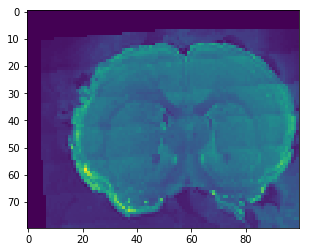

In [12]:
id = 5
plt.imshow(X_val_aug[id,:,:,0])
print(y_val_aug[id])

## Run NN model 

In [13]:
class Dataset(object):
    def __init__(self, X, y, batch_size, shuffle=False):
        """
        Construct a Dataset object to iterate over data X and labels y
        
        Inputs:
        - X: Numpy array of data, of any shape
        - y: Numpy array of labels, of any shape but with y.shape[0] == X.shape[0]
        - batch_size: Integer giving number of elements per minibatch
        - shuffle: (optional) Boolean, whether to shuffle the data on each epoch
        """
        assert X.shape[0] == y.shape[0], 'Got different numbers of data and labels'
        self.X, self.y = X, y
        self.batch_size, self.shuffle = batch_size, shuffle

    def __iter__(self):
        N, B = self.X.shape[0], self.batch_size
        idxs = np.arange(N)
        if self.shuffle:
            np.random.shuffle(idxs)
        return iter((self.X[i:i+B], self.y[i:i+B]) for i in range(0, N, B))


train_dset = Dataset(X_train_aug, y_train_aug, batch_size=100, shuffle=True)
val_dset = Dataset(X_val, y_val, batch_size=5, shuffle=False)
test_dset = Dataset(X_test, y_test, batch_size=5)

In [14]:
# We can iterate through a dataset like this:
for t, (x, y) in enumerate(train_dset):
    print(t, x.shape, y.shape)
    if t > 5: break

0 (100, 80, 100, 1) (100,)
1 (100, 80, 100, 1) (100,)
2 (100, 80, 100, 1) (100,)
3 (100, 80, 100, 1) (100,)
4 (100, 80, 100, 1) (100,)
5 (100, 80, 100, 1) (100,)
6 (100, 80, 100, 1) (100,)


In [15]:
# Set up some global variables
USE_GPU = False

if USE_GPU:
    device = '/device:GPU:0'
else:
    device = '/cpu:0'

# Constant to control how often we print when training models
print_every = 100

print('Using device: ', device)

Using device:  /cpu:0


In [16]:
def train_part34(model_init_fn, optimizer_init_fn, num_epochs=1):
    """
    Simple training loop for use with models defined using tf.keras. It trains
    a model for one epoch on the CIFAR-10 training set and periodically checks
    accuracy on the CIFAR-10 validation set.
    
    Inputs:
    - model_init_fn: A function that takes no parameters; when called it
      constructs the model we want to train: model = model_init_fn()
    - optimizer_init_fn: A function which takes no parameters; when called it
      constructs the Optimizer object we will use to optimize the model:
      optimizer = optimizer_init_fn()
    - num_epochs: The number of epochs to train for
    
    Returns: Nothing, but prints progress during trainingn
    """
    tf.reset_default_graph()    
    with tf.device(device):
        # Construct the computational graph we will use to train the model. We
        # use the model_init_fn to construct the model, declare placeholders for
        # the data and labels
        x = tf.placeholder(tf.float32, [None, 80, 100, 1])
        y = tf.placeholder(tf.int32, [None])
        
        # We need a place holder to explicitly specify if the model is in the training
        # phase or not. This is because a number of layers behaves differently in
        # training and in testing, e.g., dropout and batch normalization.
        # We pass this variable to the computation graph through feed_dict as shown below.
        is_training = tf.placeholder(tf.bool, name='is_training')
        
        # Use the model function to build the forward pass.
        scores = model_init_fn(x, is_training)

        # Compute the loss like we did in Part II
        loss = tf.losses.mean_squared_error(labels=y, predictions=tf.reshape(scores, [-1]))
        #loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=scores)
        loss = tf.reduce_mean(loss)

        # Use the optimizer_fn to construct an Optimizer, then use the optimizer
        # to set up the training step. Asking TensorFlow to evaluate the
        # train_op returned by optimizer.minimize(loss) will cause us to make a
        # single update step using the current minibatch of data.
        
        # Note that we use tf.control_dependencies to force the model to run
        # the tf.GraphKeys.UPDATE_OPS at each training step. tf.GraphKeys.UPDATE_OPS
        # holds the operators that update the states of the network.
        # For example, the tf.layers.batch_normalization function adds the running mean
        # and variance update operators to tf.GraphKeys.UPDATE_OPS.
        optimizer = optimizer_init_fn()
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(update_ops):
            train_op = optimizer.minimize(loss)

    # Now we can run the computational graph many times to train the model.
    # When we call sess.run we ask it to evaluate train_op, which causes the
    # model to update.
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        t = 0
        for epoch in range(num_epochs):
            print('Starting epoch %d' % epoch)
            for x_np, y_np in train_dset:
                feed_dict = {x: x_np, y: y_np, is_training:1}
                loss_np, _ = sess.run([loss, train_op], feed_dict=feed_dict)
                if t % print_every == 0:
                    print('Iteration %d, loss = %.4f' % (t, loss_np))
                    check_accuracy(sess, val_dset, x, scores, is_training=is_training)
                    #print()
                t += 1

In [17]:
class TwoLayerFC(tf.keras.Model):
    def __init__(self, hidden_size, num_classes):
        super().__init__()        
        initializer = tf.variance_scaling_initializer(scale=2.0)
        self.fc1 = tf.layers.Dense(hidden_size, activation=tf.nn.relu,
                                   kernel_initializer=initializer)
        self.fc2 = tf.layers.Dense(num_classes,
                                   kernel_initializer=initializer)
    def call(self, x, training=None):
        x = tf.layers.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

In [18]:
def check_accuracy(sess, dset, x, scores, is_training=None):
    """
    Check accuracy on a classification model.
    
    Inputs:
    - sess: A TensorFlow Session that will be used to run the graph
    - dset: A Dataset object on which to check accuracy
    - x: A TensorFlow placeholder Tensor where input images should be fed
    - scores: A TensorFlow Tensor representing the scores output from the
      model; this is the Tensor we will ask TensorFlow to evaluate.
      
    Returns: Nothing, but prints the accuracy of the model
    """
    num_correct, num_samples = 0, 0
    loss_total = 0
    ntotal = 0
    for x_batch, y_batch in dset:
        feed_dict = {x: x_batch, is_training: 0}
        scores_np = sess.run(scores, feed_dict=feed_dict)
        loss_total += np.sum((scores_np.flatten() - y_batch.flatten()) ** 2)
        ntotal += len(y_batch)
        #print(ntotal)
        
    print('Validation loss = %.2f' % np.sqrt(loss_total / ntotal))

In [19]:
learning_rate = 0.01

def model_init_fn(inputs, is_training):
    input_shape = (80, 100, 1)
    hidden_layer_size, num_classes = 2000, 1
    initializer = tf.variance_scaling_initializer(scale=2.0)
    layers = [
        tf.layers.Flatten(input_shape=input_shape),
        #tf.layers.Dense(hidden_layer_size, activation=tf.nn.relu,
        #                kernel_initializer=initializer),
        tf.layers.Dense(num_classes, kernel_initializer=initializer),
    ]
    model = tf.keras.Sequential(layers)
    return model(inputs)

def optimizer_init_fn():
    return tf.train.GradientDescentOptimizer(learning_rate)

train_part34(model_init_fn, optimizer_init_fn, num_epochs=1000)

Starting epoch 0
Iteration 0, loss = 2.1011
Validation loss = 115.57
Starting epoch 1
Iteration 100, loss = nan
Validation loss = nan
Starting epoch 2
Iteration 200, loss = nan
Validation loss = nan
Starting epoch 3
Starting epoch 4
Iteration 300, loss = nan
Validation loss = nan
Starting epoch 5
Iteration 400, loss = nan
Validation loss = nan
Starting epoch 6
Starting epoch 7
Iteration 500, loss = nan
Validation loss = nan
Starting epoch 8
Iteration 600, loss = nan
Validation loss = nan
Starting epoch 9
Starting epoch 10
Iteration 700, loss = nan
Validation loss = nan
Starting epoch 11
Iteration 800, loss = nan
Validation loss = nan
Starting epoch 12
Starting epoch 13
Iteration 900, loss = nan
Validation loss = nan
Starting epoch 14
Iteration 1000, loss = nan
Validation loss = nan
Starting epoch 15
Starting epoch 16
Iteration 1100, loss = nan
Validation loss = nan
Starting epoch 17
Iteration 1200, loss = nan
Validation loss = nan
Starting epoch 18
Starting epoch 19
Iteration 1300, los

Iteration 10800, loss = nan
Validation loss = nan
Starting epoch 159
Starting epoch 160
Iteration 10900, loss = nan
Validation loss = nan
Starting epoch 161
Iteration 11000, loss = nan
Validation loss = nan
Starting epoch 162
Starting epoch 163
Iteration 11100, loss = nan
Validation loss = nan
Starting epoch 164
Iteration 11200, loss = nan
Validation loss = nan
Starting epoch 165
Starting epoch 166
Iteration 11300, loss = nan
Validation loss = nan
Starting epoch 167
Iteration 11400, loss = nan
Validation loss = nan
Starting epoch 168
Starting epoch 169
Iteration 11500, loss = nan
Validation loss = nan
Starting epoch 170
Iteration 11600, loss = nan
Validation loss = nan
Starting epoch 171
Starting epoch 172
Iteration 11700, loss = nan
Validation loss = nan
Starting epoch 173
Iteration 11800, loss = nan
Validation loss = nan
Starting epoch 174
Starting epoch 175
Iteration 11900, loss = nan
Validation loss = nan
Starting epoch 176
Iteration 12000, loss = nan
Validation loss = nan
Starting

Iteration 21300, loss = nan
Validation loss = nan
Starting epoch 314
Iteration 21400, loss = nan
Validation loss = nan
Starting epoch 315
Starting epoch 316
Iteration 21500, loss = nan
Validation loss = nan
Starting epoch 317
Iteration 21600, loss = nan
Validation loss = nan
Starting epoch 318
Starting epoch 319
Iteration 21700, loss = nan
Validation loss = nan
Starting epoch 320
Iteration 21800, loss = nan
Validation loss = nan
Starting epoch 321
Starting epoch 322
Iteration 21900, loss = nan
Validation loss = nan
Starting epoch 323
Iteration 22000, loss = nan
Validation loss = nan
Starting epoch 324
Starting epoch 325
Iteration 22100, loss = nan
Validation loss = nan
Starting epoch 326
Iteration 22200, loss = nan
Validation loss = nan
Starting epoch 327
Iteration 22300, loss = nan
Validation loss = nan
Starting epoch 328
Starting epoch 329
Iteration 22400, loss = nan
Validation loss = nan
Starting epoch 330
Iteration 22500, loss = nan
Validation loss = nan
Starting epoch 331
Starting

Iteration 31900, loss = nan
Validation loss = nan
Starting epoch 470
Iteration 32000, loss = nan
Validation loss = nan
Starting epoch 471
Starting epoch 472
Iteration 32100, loss = nan
Validation loss = nan
Starting epoch 473
Iteration 32200, loss = nan
Validation loss = nan
Starting epoch 474
Starting epoch 475
Iteration 32300, loss = nan
Validation loss = nan
Starting epoch 476
Iteration 32400, loss = nan
Validation loss = nan
Starting epoch 477
Iteration 32500, loss = nan
Validation loss = nan
Starting epoch 478
Starting epoch 479
Iteration 32600, loss = nan
Validation loss = nan
Starting epoch 480
Iteration 32700, loss = nan
Validation loss = nan
Starting epoch 481
Starting epoch 482
Iteration 32800, loss = nan
Validation loss = nan
Starting epoch 483
Iteration 32900, loss = nan
Validation loss = nan
Starting epoch 484
Starting epoch 485
Iteration 33000, loss = nan
Validation loss = nan
Starting epoch 486
Iteration 33100, loss = nan
Validation loss = nan
Starting epoch 487
Starting

Starting epoch 625
Iteration 42500, loss = nan
Validation loss = nan
Starting epoch 626
Iteration 42600, loss = nan
Validation loss = nan
Starting epoch 627
Iteration 42700, loss = nan
Validation loss = nan
Starting epoch 628
Starting epoch 629
Iteration 42800, loss = nan
Validation loss = nan
Starting epoch 630
Iteration 42900, loss = nan
Validation loss = nan
Starting epoch 631
Starting epoch 632
Iteration 43000, loss = nan
Validation loss = nan
Starting epoch 633
Iteration 43100, loss = nan
Validation loss = nan
Starting epoch 634
Starting epoch 635
Iteration 43200, loss = nan
Validation loss = nan
Starting epoch 636
Iteration 43300, loss = nan
Validation loss = nan
Starting epoch 637
Starting epoch 638
Iteration 43400, loss = nan
Validation loss = nan
Starting epoch 639
Iteration 43500, loss = nan
Validation loss = nan
Starting epoch 640
Starting epoch 641
Iteration 43600, loss = nan
Validation loss = nan
Starting epoch 642
Iteration 43700, loss = nan
Validation loss = nan
Starting

Iteration 53000, loss = nan
Validation loss = nan
Starting epoch 780
Iteration 53100, loss = nan
Validation loss = nan
Starting epoch 781
Starting epoch 782
Iteration 53200, loss = nan
Validation loss = nan
Starting epoch 783
Iteration 53300, loss = nan
Validation loss = nan
Starting epoch 784
Starting epoch 785
Iteration 53400, loss = nan
Validation loss = nan
Starting epoch 786
Iteration 53500, loss = nan
Validation loss = nan
Starting epoch 787
Starting epoch 788
Iteration 53600, loss = nan
Validation loss = nan
Starting epoch 789
Iteration 53700, loss = nan
Validation loss = nan
Starting epoch 790
Starting epoch 791
Iteration 53800, loss = nan
Validation loss = nan
Starting epoch 792
Iteration 53900, loss = nan
Validation loss = nan
Starting epoch 793
Starting epoch 794
Iteration 54000, loss = nan
Validation loss = nan
Starting epoch 795
Iteration 54100, loss = nan
Validation loss = nan
Starting epoch 796
Starting epoch 797
Iteration 54200, loss = nan
Validation loss = nan
Starting

Iteration 63600, loss = nan
Validation loss = nan
Starting epoch 936
Iteration 63700, loss = nan
Validation loss = nan
Starting epoch 937
Starting epoch 938
Iteration 63800, loss = nan
Validation loss = nan
Starting epoch 939
Iteration 63900, loss = nan
Validation loss = nan
Starting epoch 940
Starting epoch 941
Iteration 64000, loss = nan
Validation loss = nan
Starting epoch 942
Iteration 64100, loss = nan
Validation loss = nan
Starting epoch 943
Starting epoch 944
Iteration 64200, loss = nan
Validation loss = nan
Starting epoch 945
Iteration 64300, loss = nan
Validation loss = nan
Starting epoch 946
Starting epoch 947
Iteration 64400, loss = nan
Validation loss = nan
Starting epoch 948
Iteration 64500, loss = nan
Validation loss = nan
Starting epoch 949
Starting epoch 950
Iteration 64600, loss = nan
Validation loss = nan
Starting epoch 951
Iteration 64700, loss = nan
Validation loss = nan
Starting epoch 952
Iteration 64800, loss = nan
Validation loss = nan
Starting epoch 953
Starting

## Keras model for NN training

In [20]:
imshape = X_test_aug.shape[1:3]
model = keras.Sequential()
model.add(keras.layers.Conv2D(32, kernel_size=(5,5), strides=(1,1),
                            activation='relu', input_shape=(imshape[0],imshape[1],1)))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(keras.layers.Conv2D(64, (5, 5), activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(1))

In [21]:
# Normalize the data: subtract the mean pixel and divide by std
mean_pixel = X_train_aug.mean(axis=(0, 1, 2), keepdims=True)
std_pixel = X_train_aug.std(axis=(0, 1, 2), keepdims=True)
X_train_aug = (X_train_aug - mean_pixel) / std_pixel
X_val_aug = (X_val_aug - mean_pixel) / std_pixel
X_test_aug = (X_test_aug - mean_pixel) / std_pixel

In [22]:
sgd = keras.optimizers.SGD(lr=0.1, clipnorm=1.)
adagrad = tf.train.AdagradOptimizer(learning_rate=10)
adam = tf.train.AdadeltaOptimizer(learning_rate=10)
model.compile(optimizer= adam, 
              loss='mean_squared_error')

model.fit(X_train_aug, y_train_aug, epochs=4)

Epoch 1/4
6800/6800 [==============================] - 51s 8ms/step - loss: 12.5942
Epoch 2/4
6800/6800 [==============================] - 51s 8ms/step - loss: 3.2102
Epoch 3/4
6800/6800 [==============================] - 51s 7ms/step - loss: 3.1682
Epoch 4/4
6800/6800 [==============================] - 52s 8ms/step - loss: 3.1650


In [23]:
# To save trained model
model.save('brain_slice_model_Adeltagrad.h5')

In [24]:
id = 3
plt.imshow(val_images[id][:,:,0])
print('Coords = ', val_coords[id], ', predicted = ', prediction_val[id])

NameError: name 'val_images' is not defined

In [ ]:
prediction_test = model.predict((X_val - mean_pixel) / std_pixel)

In [ ]:
np.mean(X_val_aug)

In [ ]:
mean_pixel

In [ ]:
np.mean((X_val/256 - mean_pixel))

In [ ]:
np.mean((y_val - prediction_test.T)**2)

In [ ]:
plt.scatter(y_val, prediction_test)
plt.plot([-3, 3], [-3, 3])

In [ ]:
plt.scatter(y_train_aug, prediction_test)

In [ ]:
prediction_test.shape

In [ ]:
zcoords.shape

In [ ]:
prediction = model.predict(train_images)


plt.scatter(train_coords, prediction)

#prediction_val = model.predict(val_images)
#plt.scatter(val_coords, prediction_val, alpha=0.5)

plt.plot([-3, 3], [-3, 3])

err = prediction_val.flatten() - val_coords
print('RMS error is', np.sqrt(np.mean(err**2)))